# Minimizing Expected Error

In [1]:
%matplotlib inline
import numpy as np
import pandas
from plotnine import *
import sys
sys.path.append('..')
from plotting import plot_linear_classifier
from plotting import plot_classifier
import time

In [2]:
def future_output_entropy(model, U, sample, model_constructor):
    p = model.predict_proba(U[['x','y']])[:,1]
    future_entropy = np.zeros(len(U))
    for i in range(0, len(U)):
        x = U[['x','y']].iloc[i]
        entropy_x = 0
        for label in [False, True]:
            lgnew = model_constructor()
            new_sample = pandas.DataFrame({'x':[x.x], 'y':[x.y], 'label':[label]})
            new_sample = new_sample.append(sample, ignore_index=True)
            new_X = new_sample[['x','y']]
            new_y = new_sample.label
            lgnew.fit(new_X, new_y)
            U_new = U[~U.index.isin(x.index)]
            pnew1 = lgnew.predict_proba(U_new[['x','y']])[:,1]
            pnew0 = 1-pnew1
            e = (pnew1 * np.log2(pnew1+0.0001) + pnew0 * np.log2(pnew0+0.0001))
            e = -np.sum(e)
            if label:
                entropy_x += e * p[i]
            else:
                entropy_x += e * (1-p[i])
        future_entropy[i] = entropy_x
    return future_entropy

In [3]:
def aktive_learn(num_samples, initial_sample, data, model, model_constructor):
    sample = initial_sample
    labeled = initial_sample.index
    unlabeled = data.index[~data.index.isin(sample.index)]
    
    for i in range(0,num_samples+1):
        sample = data.loc[labeled]
        X = sample[['x','y']]
        y = sample.label
        model.fit(X,y)
        U = data.loc[unlabeled]    
        fe = future_output_entropy(model, U, sample, model_constructor)    
        xstar_index = U.index[np.argmin(fe)]
        labeled = labeled.insert(0,xstar_index)
        unlabeled = unlabeled.drop(xstar_index)
    
    return sample

## Minimizing Expected Error

In [4]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()

In [5]:
initial_sample = data.sample(10)

In [6]:
start = time.time()
sample = aktive_learn(20, initial_sample, data, lg, lambda:LogisticRegression())
end = time.time()
print("Duration: "+ str(end - start)+" s")

Duration: 49.608577489852905 s


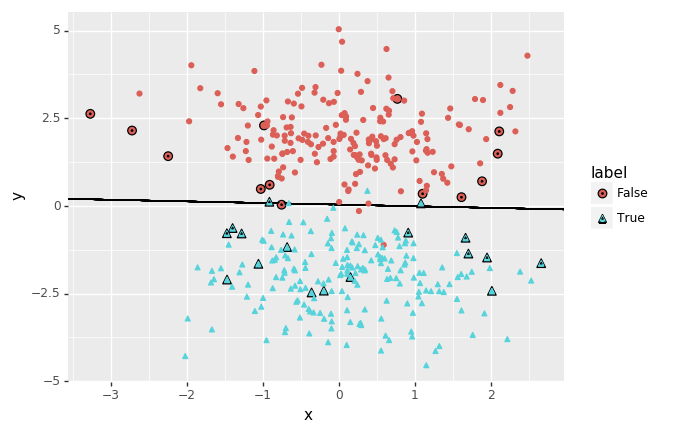

<ggplot: (8774629964506)>

In [7]:
selected = data.loc[sample.index.difference(initial_sample.index)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Minimizing Error, outliers

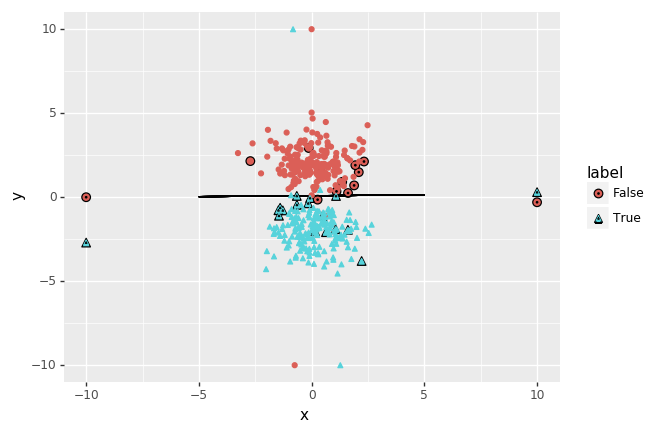

<ggplot: (8774627591828)>

In [8]:
data = pandas.read_pickle('../data/two_2dgaussians_with_outliers.pkl')
initial_sample = data.sample(10)
sample = aktive_learn(20, initial_sample, data, lg, lambda:LogisticRegression())
selected = data.loc[sample.index.difference(initial_sample.index)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Minimizing Error, skewed data

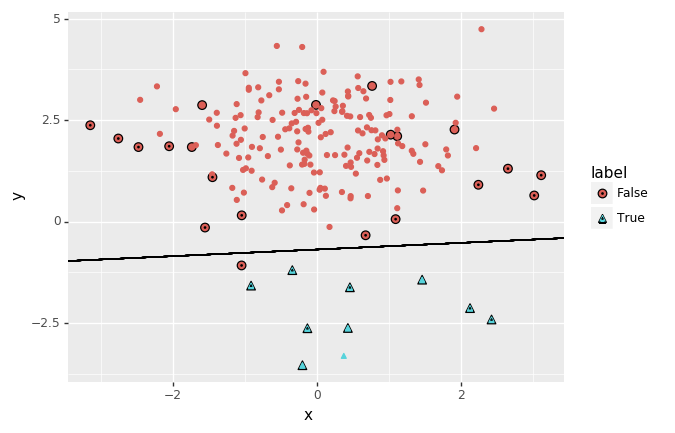

<ggplot: (8774629971695)>

In [9]:
data = pandas.read_pickle('../data/two_2dgaussians_skewed.pkl')
initial_sample = data[data.label==True].sample(1)
initial_sample = initial_sample.append(data.sample(9))
sample = aktive_learn(20, initial_sample, data, lg, lambda:LogisticRegression())
selected = data.loc[sample.index.difference(initial_sample.index)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Minimizing Error, biased data

### Toy Dataset

In [10]:
data = pandas.read_pickle('../data/three_2dgaussians.pkl')

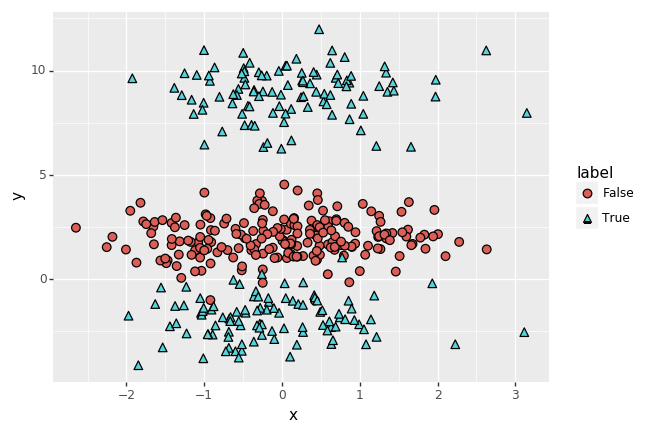

<ggplot: (8774626960339)>

In [11]:
ggplot(data, aes(x='x', y='y', fill='label', shape='label'))+geom_point(size=3)

In [12]:
sample = data[data.y<5].sample(20)
labeled = sample.index
labeled_initial = labeled
unlabeled = data.index[~data.index.isin(sample.index)]

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=2, min_samples_leaf=2) 

### Initial model

In [14]:
sample = data[data.y<5].sample(20)
X = sample[['x','y']]
y = sample.label
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

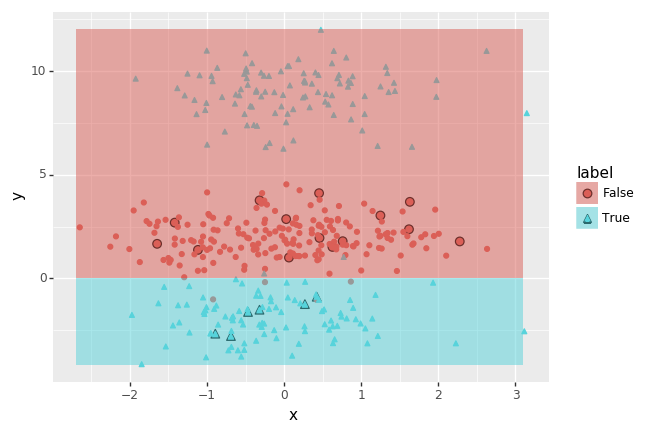

<ggplot: (8774626627069)>

In [15]:
plot_classifier(sample, data, rf)

### After active learning

In [16]:
import time
start = time.time()

for i in range(0,21):
    sample = data.loc[labeled]
    X = sample[['x','y']]
    y = sample.label
    rf.fit(X,y)
    U = data.loc[unlabeled]    
    fe = future_output_entropy(rf, U, sample, lambda:RandomForestClassifier(n_estimators=100, max_features=2, min_samples_leaf=2) )    
    xstar_index = U.index[np.argmin(fe)]
    labeled = labeled.insert(0,xstar_index)
    unlabeled = unlabeled.drop(xstar_index)
    
end = time.time()
print("Duration: "+ str(end - start)+" s")

Duration: 1295.8304493427277 s


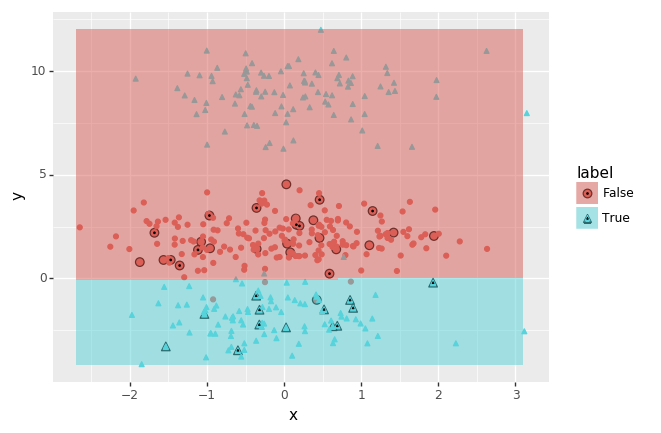

<ggplot: (-9223363262227850082)>

In [17]:
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, rf)+geom_point(selected,aes(x='x',y='y'), size=0.1)

# Variance Reduction

expected error = noise + bias (= model/feature inadequacies) + output variance

=> minimizing output variance minimizes the error for a given model + feature set.

Methods exists to calculate the output variance in closed form for linear regression and logistic regression.
Using libact http://libact.readthedocs.io/en/latest/

In [18]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')

In [19]:
import libact;
from libact.base.dataset import Dataset
from libact.query_strategies import *
from libact.labelers.ideal_labeler import IdealLabeler

In [20]:
lg = libact.models.logistic_regression.LogisticRegression()
labeled_dataset = Dataset(data[['x','y']].values, data.label.values)
sample = data.sample(10)
ds = data.copy()
ds.label = None
ds.loc[sample.index,'label'] = sample.label

dataset = Dataset(ds[['x','y']].values, ds.label.values)
query_strategy = VarianceReduction(dataset, model=lg, sigma=100)
#query_strategy = UncertaintySampling(dataset, model=lg)
labeler = IdealLabeler(labeled_dataset)

In [21]:
for i in range(0,21):
    query_id = query_strategy.make_query()
    lbl = labeler.label(dataset.data[query_id][0])     
    dataset.update(query_id, lbl)
    lg.train(dataset)

In [22]:
idx = list(filter(lambda i: dataset.data[i][1] is not None, range(0,len(dataset.data))))    

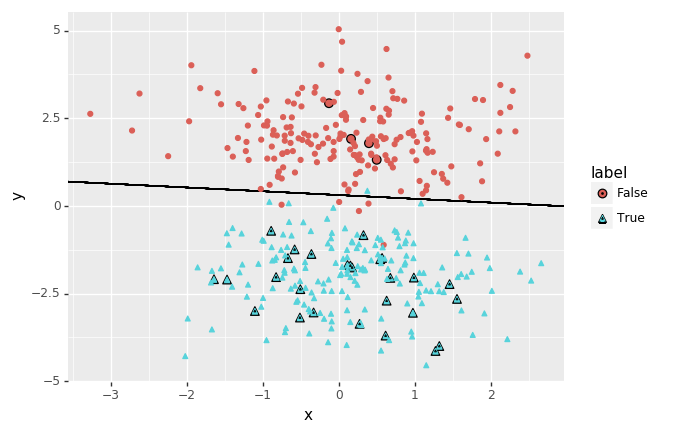

<ggplot: (-9223363262224805523)>

In [23]:
labeled_initial = sample.index
sample = data.loc[idx]
selected = data.loc[sample.index.difference(labeled_initial)]
plot_linear_classifier(sample,data,lg.model)+geom_point(selected,aes(x='x',y='y'), size=0.1)

Doesn't seem to work very well, picks only positive samples in a seemingly random fashion...